In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
from pathlib import Path
directory = Path.joinpath(Path.cwd(),'images')
# Filename
filename = 'human.png'

img_path = Path.joinpath(directory,filename)
print(img_path)
str_img_path = str(img_path)

/aiffel/aiffel/human_segmentation/images/human.png


(352, 626, 3)


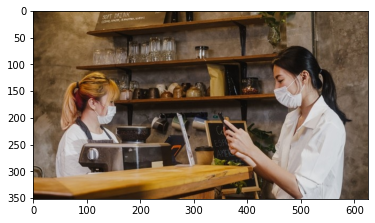

In [3]:
img_orig = cv2.imread(str_img_path) 
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
# model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_dir = Path.joinpath(Path.cwd(),'models')
model_file= Path.joinpath(model_dir,'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# # PixelLib가 제공하는 모델의 url입니다
# model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# # 다운로드를 시작합니다
# urllib.request.urlretrieve(model_url, model_file)

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [7]:
#  PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES) 

21

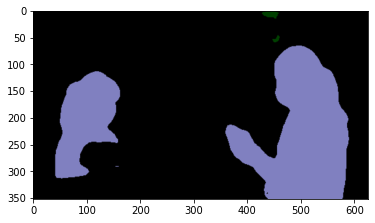

In [8]:
plt.imshow(output)
plt.show()

In [9]:
segvalues

{'class_ids': array([ 0, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


In [11]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
colormap[15]

array([192, 128, 128])

In [13]:
# output 이미지는 BGR 순서. colormap은 RGB 순서
seg_color = (128,128,192) # 코드에서는 BGR 순서로 바꿔서 활용

(352, 626)


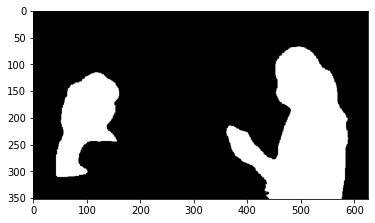

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

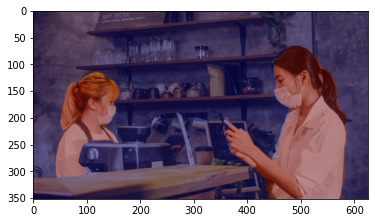

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

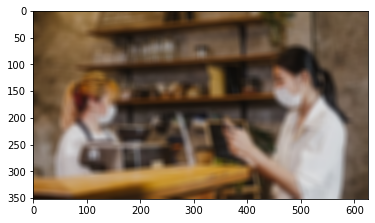

In [16]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))   # blur() 함수를 이용
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()


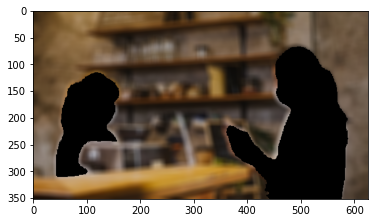

In [17]:
#  흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)  # bitwise_not 함수를 이용하면 이미지가 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

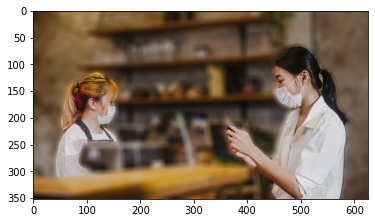

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
directory = Path.joinpath(Path.cwd(),'images')
filename = 'human2.png'
img_path = Path.joinpath(directory,filename)
print(img_path)
str_img_path = str(img_path)
cv2.imwrite(str_img_path, img_concat)

/aiffel/aiffel/human_segmentation/images/human2.png


True

![human-1.png](r'.\images\human-1.png')

### 보케가 있는 사진 만들기 입니다.

In [20]:
def outFocus(directory, filename):
    
    '''
    사진화일이 있는 '디렉토리'와 '사진이름'을 받아들여서 
    그 디렉토리에 
    아웃포커스된 이미지를 사진이름-1.png 로 저장한다.
    '''
    img_path = Path.joinpath(directory,filename)
    str_img_path = str(img_path)
    
    img_orig = cv2.imread(str_img_path) 
    
    # 인식 가능한 21가지 사물
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    
    
    # PixelLib에서 정해둔 colormap 코드입니다
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
#     colormap[:20]    
    
    
    segvalues, output = model.segmentAsPascalvoc(img_path)
#     plt.imshow(output)
#     plt.show()        
    
    id_number = 0
    class_you_want = ''
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
        if id_number == 1 : # 0번째는 배경 1번째부터 21가지 사물이 인식됨
            class_you_want = LABEL_NAMES[class_id]
            
        if 'person' == LABEL_NAMES[class_id]:
            class_you_want = 'person'
        
        id_number = id_number + 1
        
    r = 0 
    g = 0 
    b = 0
    # output 이미지는 BGR 순서. colormap은 RGB 순서    
    for i in range(20):
        if class_you_want == LABEL_NAMES[i]:
            r = colormap[i][0]
            g = colormap[i][1]
            b = colormap[i][2]

    seg_color = (b, g, r)

    
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    seg_map = np.all(output==seg_color, axis=-1)
#     print(seg_map.shape)
#     plt.imshow(seg_map, cmap='gray')
#     plt.show()


    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
#     plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
#     plt.show()
    
    
    # blur(img_orig, (10,10))  10을 변화시켜 블러 정도를 조절
    img_orig_blur = cv2.blur(img_orig, (10,10))   # blur() 함수를 이용
#     plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
#     plt.show()

    #  흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)  # bitwise_not 함수를 이용하면 이미지가 반전
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()
    
    
    filename = filename[:-4] +'-1.png'
    img_path = Path.joinpath(directory,filename)
    str_img_path = str(img_path)
    cv2.imwrite(str_img_path, img_concat)
    
    print('Image file saved OK!')

background
person


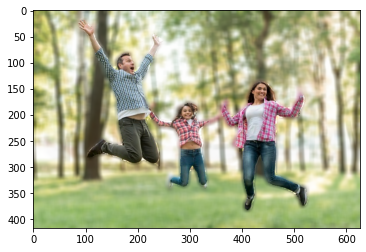

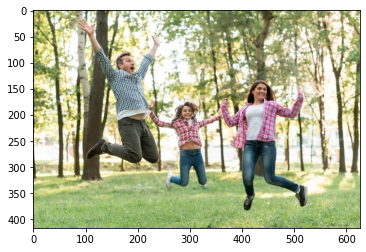

Image file saved OK!


In [21]:

filename = 'family.png'
outFocus(directory, filename)

background
cat


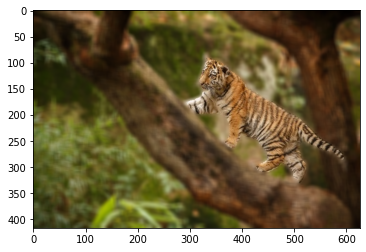

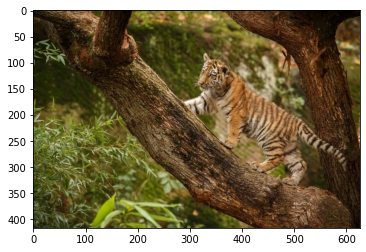

Image file saved OK!


In [22]:
filename = 'cat.png'
outFocus(directory, filename)

background
bird


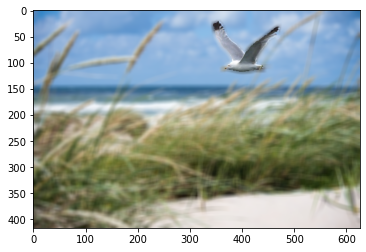

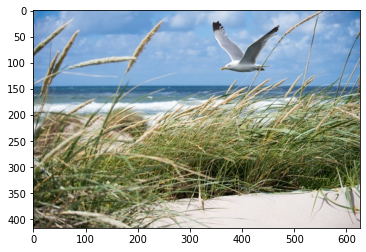

Image file saved OK!


In [23]:
filename = 'bird.png'
outFocus(directory, filename)

background
bird


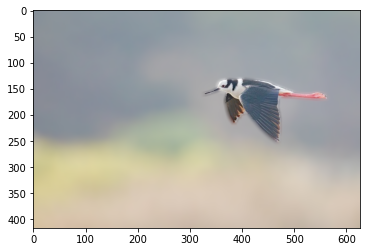

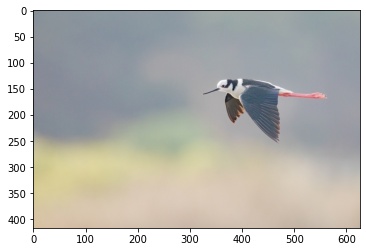

Image file saved OK!


In [24]:
filename = 'bird1.png'
outFocus(directory, filename)

## Step 1. 인물모드 직접 해 보기

### 3장 이상의 인물모드 사진

background
chair
person


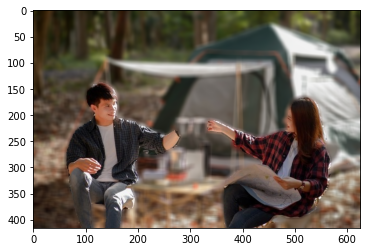

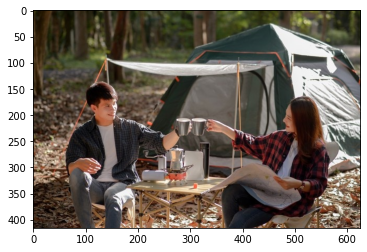

Image file saved OK!


In [25]:
filename = 'young-couple.png'
outFocus(directory, filename)

background
person


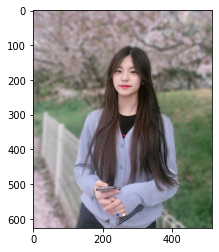

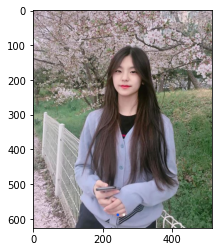

Image file saved OK!


In [26]:
filename = 'my_image.png'
outFocus(directory, filename)

background
person
pottedplant


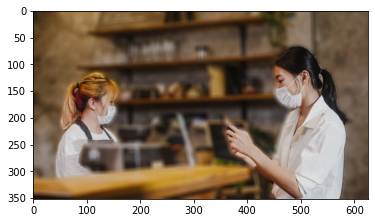

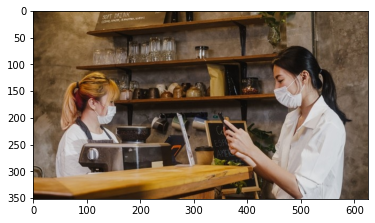

Image file saved OK!


In [27]:
filename = 'human.png'
outFocus(directory, filename)

### 합성사진 만들기 입니다.

In [28]:
def compositePhotograph(directory, filename, background):
    
    '''
    사진화일이 있는 '디렉토리'와 '사진이름' 그리고 '배경사진이름'을 받아들여서 
    그 디렉토리에 
    합성된 이미지를 사진이름-comp.png 로 저장한다.
    
    배경사진과 합성하려는 사진은 사이즈가 같아야 합니다.
    '''
    img_path            = Path.joinpath(directory,filename)
    str_img_path        = str(img_path)
    img_orig            = cv2.imread(str_img_path) 
    
    background_path     = Path.joinpath(directory,background)
    str_background_path = str(background_path)
    bg_orig             = cv2.imread(str_background_path) 
    
    # 인식 가능한 21가지 사물
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    
    
    # PixelLib에서 정해둔 colormap 코드입니다
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
#     colormap[:20]    
    
    
    segvalues, output = model.segmentAsPascalvoc(img_path)
#     plt.imshow(output)
#     plt.show()        
    
    id_number = 0
    class_you_want = ''
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
        if id_number == 1 : # 0번째는 배경 1번째 부터 21가지 사물이 인식됨
            class_you_want = LABEL_NAMES[class_id]
            
        if 'person' == LABEL_NAMES[class_id]:
            class_you_want = 'person'            
            
        id_number = id_number + 1

        
    r = 0 
    g = 0 
    b = 0
    # output 이미지는 BGR 순서. colormap은 RGB 순서    
    for i in range(20):
        if class_you_want == LABEL_NAMES[i]:
            r = colormap[i][0]
            g = colormap[i][1]
            b = colormap[i][2]

    seg_color = (b, g, r)

    
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    seg_map = np.all(output==seg_color, axis=-1)
#     print(seg_map.shape)
#     plt.imshow(seg_map, cmap='gray')
#     plt.show()


    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
#     plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
#     plt.show()
    
    
    # blur(img_orig, (10,10))  10을 변화시켜 블러 정도를 조절
#     img_orig_blur = cv2.blur(img_orig, (10,10))   # blur() 함수를 이용
#     plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
#     plt.show()

    #  흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask    = cv2.bitwise_not(img_mask_color)  # bitwise_not 함수를 이용하면 이미지가 반전
#    img_bg_blur     = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    img_bg         = cv2.bitwise_and(bg_orig, img_bg_mask)



#     img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg)    
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()
    
    plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
    plt.show()    
    
    
    filename = filename[:-4] +'-comp.png'
    img_path = Path.joinpath(directory,filename)
    str_img_path = str(img_path)
    cv2.imwrite(str_img_path, img_concat)
    
    print('Image file saved OK!')    
    
    

### 크로마키 배경 합성을 시도

background
bird


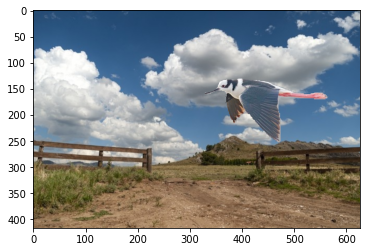

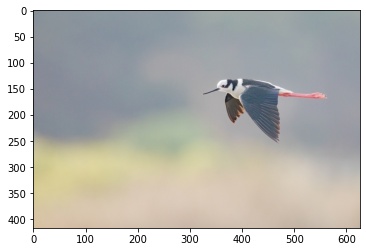

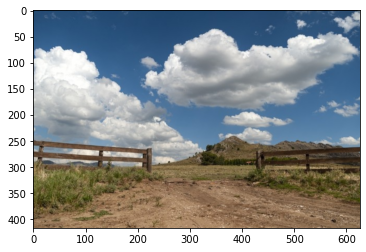

Image file saved OK!


In [29]:
filename   = 'bird1.png'
background = 'valley.png'
compositePhotograph(directory, filename, background)

background
person


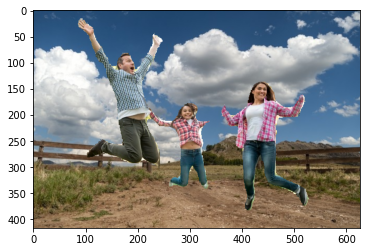

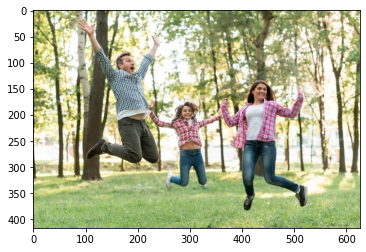

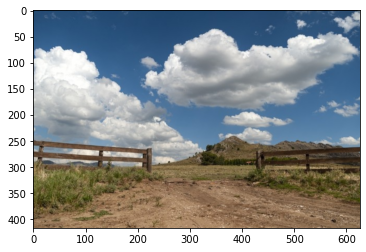

Image file saved OK!


In [30]:
filename   = 'family.png'
background = 'valley.png'
compositePhotograph(directory, filename, background)

background
bird


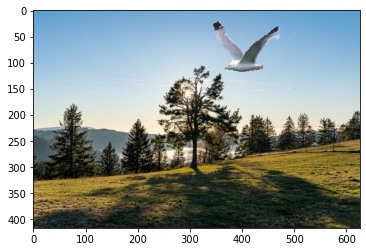

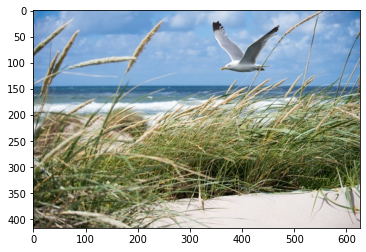

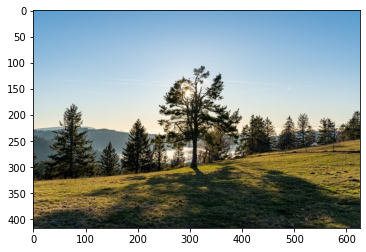

Image file saved OK!


In [32]:
filename   = 'bird.png'
background = 'forest.png'
compositePhotograph(directory, filename, background)

## Step 2. 사진에서 문제점 찾기

### 이상한 점 표시한 이미지들

![human2-2.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/human2-2.png)

![my_image-2.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/my_image-2.png)

![young-couple-2.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/young-couple-2.png)

## Step 3. 해결 방법을 제안해 보기

1. 피사계 심도가 다른 렌즈 두개를 사용하여 같은 피사체를 동시에 찍은 후 두 사진의 차이점을 강조해서 합성 - 이미 상용화 되어있는 것으로 알고 있음

2. 위치가 다른 두개의 카메라를 사용해서 스테레오 이미지를 얻은 후 거리에 따라 블러를 준다. - 이미 상용화 되어있는 것으로 알고 있음

3. 하나의 카메라를 이동시켜 두개의 이미지를 얻은 후 2번의 방법으로 블러를 준다.

4. 구글의 경우 하나의 비디오 카메라로 3차원 인식(카메라의 전후좌우 이동이 있어야 ...)하는 인공지능을 개발하고 있다.

5. F값이 적은 밝고 큰 렌즈를 쓴다. 